# Programming Assignment 1: Implementing Configurable Program Analysis

## Instructions for Submission and Grading

- Deadline: **2025-04-08**
- Total points: 100
  - There are 10 tasks with 80 points in this Jupyter notebook
  - We will use 4 hidden programs to test your verifier (20 points, 5 points each)
- Submission: Upload your finished Jupyter notebook file (i.e., this file) to NTU COOL.

## Description

This programming assignment asks you to implement a minimal software verifier
based on *Configurable Program Analysis*, the core concept in our course.
You will practice and apply the concept of CPA by getting your hands dirty.

The verifier we are going to implement can analyze Python code with basic constructs.
We leave out the language features unnecessary for grasping the concepts by limiting our verifier to:

* only integers and Booleans like `True` and `False`
* only the following operators in expressions: `+ - * / == !=`
* only `while` loops, `break`, and `continue`, but no for-each loops
* only assignments of the simple form `a = b + c` (no augmented assignments like ` a += b` or multiple assignments like `(a,b,c) = (1,2,3)`)
* not consider function declarations. Functions are only used to
    1. mark target states (by calling `reach_error()`)  
    2. generate nondeterministic values (by calling `nondet()`)  
    (These functions can be assumed already-declared, i.e., no need to be declared.)

Please follow the explanations below to implement the verifier step by step by filling in the TODOs.
You can test your implementation with the provided programs.

## 1. Parsing an input program and generating a CFA (3 tasks, 20 points)

In this part, we will look at how we can get a CFA from an abstract syntax tree (AST),
which we will use the Python package `ast` to produce from a given Python program.

### 1.1 Visualizing the AST

A frequently used design pattern to extract information from an AST is the [*visitor pattern*](https://refactoring.guru/design-patterns/visitor).
In this exercise, we will use it to visualize the AST.
In later tasks, we will use it for all kinds of other things, like generating the CFA, evaluating expressions, etc.
We will use the following example program that contains most of the considered syntactical features:

In [1]:
ast_program = \
"""
i = 0
j = nondet()
while i<100:
  if i == 47:
    j = j * 2 - 1
    reach_error()
    break
  else:
    i = i + 1
    continue
  i = i - 1
"""

In order to parse this program into an AST, we use the package `ast` :

In [2]:
import ast
import astpretty
tree = ast.parse(ast_program)
astpretty.pprint(tree, show_offsets=False)

Module(
    body=[
        Assign(
            targets=[Name(id='i', ctx=Store())],
            value=Constant(value=0, kind=None),
            type_comment=None,
        ),
        Assign(
            targets=[Name(id='j', ctx=Store())],
            value=Call(
                func=Name(id='nondet', ctx=Load()),
                args=[],
                keywords=[],
            ),
            type_comment=None,
        ),
        While(
            test=Compare(
                left=Name(id='i', ctx=Load()),
                ops=[Lt()],
                comparators=[Constant(value=100, kind=None)],
            ),
            body=[
                If(
                    test=Compare(
                        left=Name(id='i', ctx=Load()),
                        ops=[Eq()],
                        comparators=[Constant(value=47, kind=None)],
                    ),
                    body=[
                        Assign(
                            targets=[Name(id='j', ctx=Store())],
 

This textual representation shows how the AST decomposes the source code into syntactical building blocks.
More details can be found at https://docs.python.org/3/library/ast.html.
Basically, every element from the grammar has a corresponding class used in the AST, which is also used for the visitor pattern.

There is a predefined class `ast.NodeVisitor` from which we can inherit.
This class contains a method `generic_visit(self, node)` that is called for every node while traversing the AST.
Below is a simple example of a class `ASTPrinter(ast.NodeVisitor)` that visits each node and
prints the node's class as well as a number identifying in which order the nodes are explored.

Furthermore, `ast.NodeVisitor` contains a method `visit_<classname>(self,node)` for every class name that can appear in the AST.
The default implementation of `generic_visit(self, node)` makes sure that
this method is called once a corresponding node is encountered in the AST during traversal.
In the example below, we overwrote one of those methods to show you how this feature can be used.
Please notice that we still need to call `generic_visit`,
otherwise the traversal of the AST will stop and child nodes will not be visited.

In [3]:
class ASTPrinter(ast.NodeVisitor):
    def __init__(self):
        self.node_counter = 0
    def generic_visit(self, node):
        node_name = "%d %s" % (self.node_counter, node.__class__.__name__)
        self.node_counter += 1
        print(node_name)
        return ast.NodeVisitor.generic_visit(self, node)
    def visit_Assign(self, node):
        print("Found an assign node:")
        self.generic_visit(node)
        

astvisitor = ASTPrinter()
astvisitor.visit(tree)

0 Module
Found an assign node:
1 Assign
2 Name
3 Store
4 Constant
Found an assign node:
5 Assign
6 Name
7 Store
8 Call
9 Name
10 Load
11 While
12 Compare
13 Name
14 Load
15 Lt
16 Constant
17 If
18 Compare
19 Name
20 Load
21 Eq
22 Constant
Found an assign node:
23 Assign
24 Name
25 Store
26 BinOp
27 BinOp
28 Name
29 Load
30 Mult
31 Constant
32 Sub
33 Constant
34 Expr
35 Call
36 Name
37 Load
38 Break
Found an assign node:
39 Assign
40 Name
41 Store
42 BinOp
43 Name
44 Load
45 Add
46 Constant
47 Continue
Found an assign node:
48 Assign
49 Name
50 Store
51 BinOp
52 Name
53 Load
54 Sub
55 Constant


#### Task 1: Visitor that counts `Name` nodes (3 points)

Write a visitor that counts the number of `Name` nodes in an AST:

In [4]:
class ASTNameCounter(ast.NodeVisitor):
    def __init__(self):
        self.count = 0
    # DONE Task 1
    def visit_Name(self, node):
        self.count += 1
        return ast.NodeVisitor.generic_visit(self, node)
        
astvisitor = ASTNameCounter()
astvisitor.visit(tree)
print(astvisitor.count)

12


#### Task 2: Visitor that visualizes the AST (7 points)

Write a visitor that visualizes the AST as a tree.
You can use `graphviz` for visualization. The following is an example.

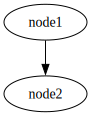

In [5]:
from graphviz import Digraph
dot = Digraph()
dot.node("node1")
dot.node("node2")
dot.edge("node1","node2")
dot # last statement will be printed in Jupyter Notebook. If it is a graphviz graph, it will be drawn.

You might want to keep track of the stack of parent nodes while you are traversing the AST.
(Feel free to add more attributes to the class if needed.)

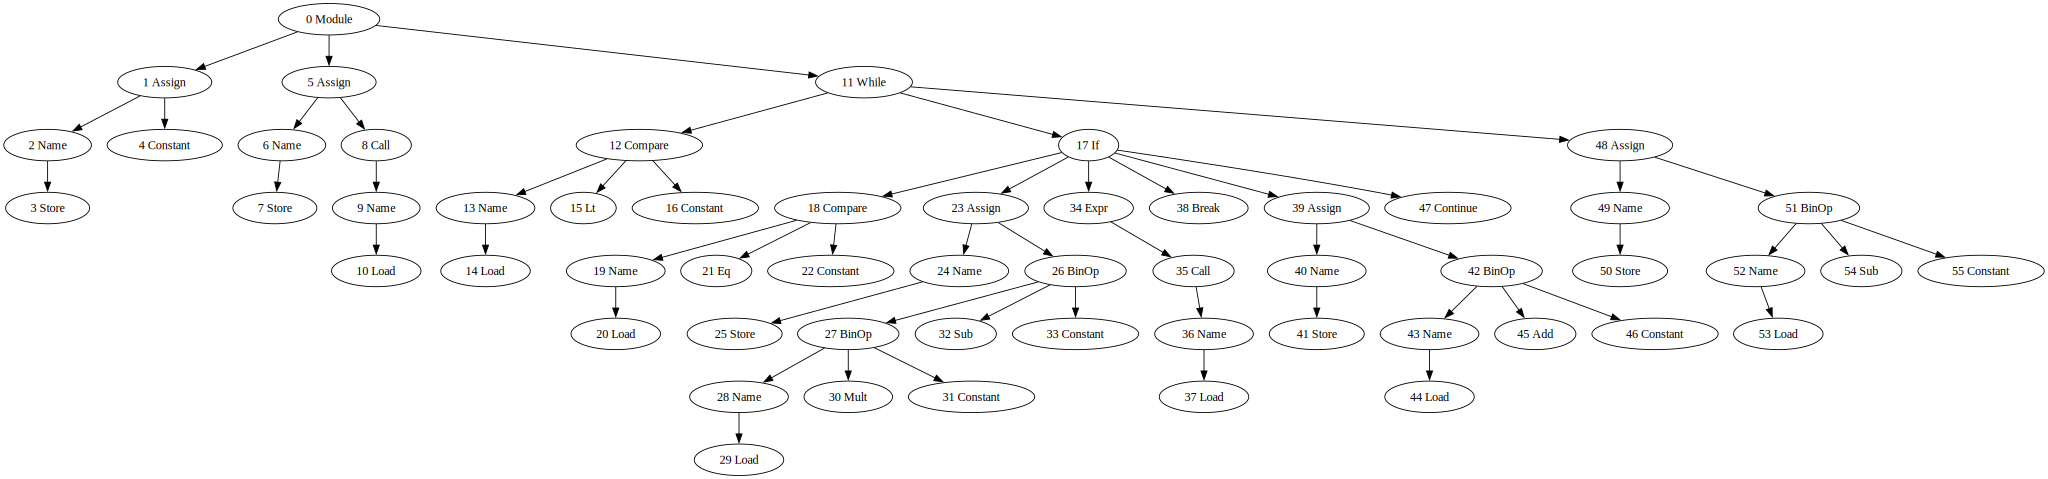

In [6]:
# DONE Task 2: Implementation of a visitor that plots the Abstract Syntax Tree as a graphviz graph
from graphviz import Digraph

class ASTVisualizer(ast.NodeVisitor):
    def __init__(self):
        self.node_stack = list()
        self.graph = Digraph()
        self.node_counter = 0
        
    # DONE Task 2: add implementation here
    def generic_visit(self, node):
        # using this name in the displayed AST
        node_name = "%d %s" % (self.node_counter, node.__class__.__name__)
        self.node_counter += 1
        self.graph.node(node_name)

        # get parent node's name from stack and create an edge
        if len(self.node_stack) > 0:
            self.graph.edge(self.node_stack[-1], node_name)
            self.node_stack.pop()
        
        # for each child, push this node's name on the stack
        for c in ast.iter_child_nodes(node):
            self.node_stack.append(node_name)
        
        return ast.NodeVisitor.generic_visit(self, node)
        
astvisitor = ASTVisualizer()
astvisitor.visit(tree)
astvisitor.graph

### 1.2 Converting the AST into a CFA

For verification, we usually want to get the CFA of the program as an input.
Constructing the CFA from an AST can be elegantly done using a visitor.
Our strategy is to consider all nodes that affect control flow and
take those subtrees that do not directly affect the control flow (like assumptions and statements) as edges in our CFA.
We will call something that is either an assumption or a statement an `Instruction`.
We also add some static utility methods to create `Instruction`s of both `InstructionType`s
and negate an assumption in case it is on the `else` branch:

In [7]:
from enum import Enum
class InstructionType(Enum):
    STATEMENT = 1
    ASSUMPTION = 2


class Instruction:
    """An instruction is either an assignment or an assumption"""

    def __init__(self, expression, kind=InstructionType.STATEMENT, negated=False):
        self.kind = kind
        self.expression = expression
        self.negated = negated  # we might need this information at some point

    @staticmethod
    def assumption(expression, negated=False):
        if negated:
            expression = ast.UnaryOp(op=ast.Not(), operand=expression)
        return Instruction(expression, kind=InstructionType.ASSUMPTION, negated=negated)

    @staticmethod
    def statement(expression):
        return Instruction(expression)

The  CFA then consists of nodes and edges, for which we declare separate classes.
A `CFANode` has a numeric node id and a list of leaving and entering edges.
A `CFAEdge` contains an `Instruction` as well as references to its predecessor and successor `CFANode`s:

In [8]:
import astunparse

class CFANode:
    index = 0

    def __init__(self):
        self.node_id = CFANode.index
        self.entering_edges = list()
        self.leaving_edges = list()
        CFANode.index += 1

    def __str__(self):
        return "(%s)" % str(self.node_id)

    @staticmethod
    def merge(a, b):
        for entering_edge in b.entering_edges:
            entering_edge.successor = a
            a.entering_edges.append(entering_edge)
        for leaving_edge in b.leaving_edges:
            leaving_edge.predecessor = a
            a.leaving_edges.append(leaving_edge)
        b.entering_edges = list()
        b.leaving_edges = list()
        if CFANode.index == b.node_id + 1:
            CFANode.index -= 1
        return a

class CFAEdge:
    def __init__(self, predecessor, successor, instruction):
        self.predecessor = predecessor
        self.successor = successor
        predecessor.leaving_edges.append(self)
        successor.entering_edges.append(self)
        self.instruction = instruction

    def __str__(self):
        return "%s -%s-> %s" % (
            str(self.predecessor),
            self.label(),
            str(self.successor),
        )

    def label(self):
        return astunparse.unparse(self.instruction.expression).strip()

#### Task 3: Creating a CFA from an AST using a visitor (10 points)

The basic idea is to keep a stack of CFANodes (`self.node_stack`)
where the top-most element always points to the node where we append the subgraph generated for the current node (and its children).
Upon entering a node, we generally pop that CFANode from the stack since this is where we append new nodes.
Once we are done with a node we push its leaving edges back to the stack.

The following implementation has everything needed for simple programs.
It just lacks implementation for `break` and `continue`, which will be your task to add.
(The current implementation considers these statements as no-ops. Please fix it.)

In [9]:
import ast

class CFACreator(ast.NodeVisitor):
    def __init__(self):
        self.root = CFANode()
        self.node_stack = list()
        self.node_stack.append(self.root)
        self.continue_stack = list()
        self.break_stack = list()

    def visit_FunctionDef(self, node):
        ast.NodeVisitor.generic_visit(self, node)
    
    def visit_While(self, node): # Note: implement TODOs for break and continue to handle them inside while-loops
        entry_node = self.node_stack.pop()
        inside = CFANode()
        self.continue_stack.append(entry_node)
        edge = CFAEdge(entry_node, inside, Instruction.assumption(node.test))
        outside = CFANode()
        self.break_stack.append(outside)
        edge = CFAEdge(
            entry_node, outside, Instruction.assumption(node.test, negated=True)
        )
        self.node_stack.append(inside)
        for statement in node.body:
            self.visit(statement)
        body_exit_node = self.node_stack.pop()
        CFANode.merge(entry_node, body_exit_node)
        self.node_stack.append(outside)
        self.continue_stack.pop()
        self.break_stack.pop()
    
    # DONE Task 3 (add proper implementation for break)
    def visit_Break(self, node):
        entry_node = self.node_stack.pop()
        next_node = CFANode()            # create node for next line after break

        # make edge from entry node to break node
        edge = CFAEdge(
            entry_node, self.break_stack[-1], Instruction.statement(node)
        )

        self.node_stack.append(next_node)
        return 

    # DONE Task 3 (add proper implementation for continue)
    def visit_Continue(self, node):
        entry_node = self.node_stack.pop()
        next_node = CFANode()             # create node for next line after break

        # make edge from entry node to continue node
        edge = CFAEdge(
            entry_node, self.continue_stack[-1], Instruction.statement(node)
        )

        self.node_stack.append(next_node)
        return
        
    def visit_If(self, node):
        entry_node = self.node_stack.pop()
        left = CFANode()
        edge = CFAEdge(entry_node, left, Instruction.assumption(node.test))
        right = CFANode()
        edge = CFAEdge(
            entry_node, right, Instruction.assumption(node.test, negated=True)
        )
        self.node_stack.append(left)
        for statement in node.body:
            self.visit(statement)
        left_exit = self.node_stack.pop()
        self.node_stack.append(right)
        for statement in node.orelse:
            self.visit(statement)
        right_exit = self.node_stack.pop()
        merged_exit = CFANode.merge(left_exit, right_exit)
        self.node_stack.append(merged_exit)

    def visit_Expr(self, node):
        entry_node = self.node_stack.pop()
        exit_node = CFANode()
        edge = CFAEdge(entry_node, exit_node, Instruction.statement(node.value))
        self.node_stack.append(exit_node)

    def visit_Assign(self, node):
        entry_node = self.node_stack.pop()
        exit_node = CFANode()
        edge = CFAEdge(entry_node, exit_node, Instruction.statement(node))
        self.node_stack.append(exit_node)

You can use the code below to draw the generated CFAs for manual inspection.
Essentially, a `CFANode` is wrapped into `GraphableCFANode`, which implements the `Graphable` interface.
The method `graphable_to_dot` then takes a `Graphable` state and plots everything that is reachable from that state.

In [10]:
class Graphable:
    def get_node_label(self):
        pass

    def get_edge_labels(self, other):
        pass

    def get_successors(self):
        pass

class GraphableCFANode(Graphable):
    def __init__(self, node):
        assert isinstance(node, CFANode)
        self.node = node

    def get_node_label(self):
        return str(self.node.node_id)

    def get_edge_labels(self, other):
        return [
            edge.label()
            for edge in self.node.leaving_edges
            if edge.successor == other.node
        ]

    def get_successors(self):
        return [GraphableCFANode(edge.successor) for edge in self.node.leaving_edges]

    def __eq__(self, other):
        return self.node == other.node

    def __hash__(self):
        return self.node.__hash__()

def graphable_to_dot(root, nodeattrs={"shape": "circle"}):
    dot = Digraph()
    for (key, value) in nodeattrs.items():
        dot.attr("node", [(key, value)])
    dot.node(root.get_node_label())
    waitlist = set()
    waitlist.add(root)
    reached = set()
    reached.add(root)
    while not len(waitlist) == 0:
        node = waitlist.pop()
        for successor in node.get_successors():
            for edgelabel in node.get_edge_labels(successor):
                dot.edge(node.get_node_label(), successor.get_node_label(), edgelabel)
            if not successor in reached:
                waitlist.add(successor)
                reached.add(successor)
                dot.node(successor.get_node_label())
    return dot

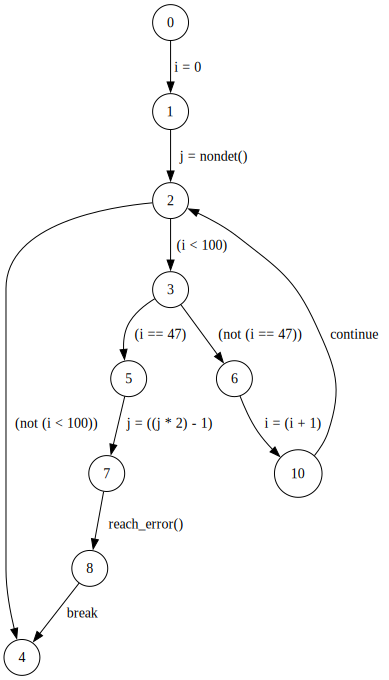

In [11]:
CFANode.index = 0  # reset the CFA node indices to produce identical output on re-execution
visitor = CFACreator()
visitor.visit(tree)
cfa_root = visitor.root
graphable_to_dot(GraphableCFANode(cfa_root))

## 2. Introducing CPAs (7 tasks, 72 points)

Now that we managed to create CFAs from our programs, it is time to build the basis for verification.
As we learned, a flexible way to describe data-flow analysis and model checking is
using the concept of Configurable Program Analysis (CPA).
The basic interface of CPA is given below:

In [12]:
from typing import Collection


class AbstractState(object):
    pass


class TransferRelation:
    def get_abstract_successors(self, predecessor: AbstractState) -> Collection[AbstractState]:
        raise NotImplementedError("get_abstract_successors not implemented!")

    def get_abstract_successors_for_edge(self, predecessor: AbstractState, edge: CFAEdge) -> Collection[AbstractState]:
        raise NotImplementedError("get_abstract_successors_for_edge not implemented!")


class StopOperator:
    def stop(self, state: AbstractState, reached: Collection[AbstractState]) -> bool:
        raise NotImplementedError("stop not implemented!")


class MergeOperator:
    def merge(self, state1: AbstractState, state2: AbstractState) -> AbstractState:
        raise NotImplementedError("merge not implemented!")

    
class CPA:
    def get_initial_state(self) -> AbstractState:
        raise NotImplementedError("get_initial_state not implemented!")

    def get_transfer_relation(self) -> TransferRelation:
        raise NotImplementedError("get_transfer_relation not implemented!")

    def get_merge_operator(self) -> MergeOperator:
        raise NotImplementedError("get_merge_operator not implemented!")

    def get_stop_operator(self) -> StopOperator:
        raise NotImplementedError("get_stop_operator not implemented!")

In `TransferRelation`, we have
- $e \rightsquigarrow e'$ as `get_abstract_successors(self, predecessor)` and
- $e \stackrel{g}{\rightsquigarrow} e'$ as `get_abstract_successors_for_edge(self, predecessor, edge)`,
  where $g$ corresponds to the `CFAEdge` named `edge`.

#### Task 4: Merge-Sep and Stop-Sep Operators (6 points)

Please define the merge-sep and stop-sep operators according to what we have learned in the class:

In [13]:
class MergeSepOperator(MergeOperator):
    # DONE Task 4
    def merge(self, e: AbstractState, eprime: AbstractState) -> AbstractState:
        return eprime


class StopSepOperator(StopOperator):
    def __init__(self, subsumes):
        self.subsumes = subsumes
    # DONE Task 4
    def stop(self, state: AbstractState, reached: Collection[AbstractState]) -> bool:
        return any((self.subsumes(state, reached_state) for reached_state in reached))

### LocationCPA

We will implement a CPA $\mathbb{L}$ that tracks the current location in the program,
which is called *LocationCPA*.

#### Task 5: Implementing transfer relation and stop operator of LocationCPA (6 points)

We will implement the transfer relation, which returns the successor location,
and the stop operator, which returns true if a location has been explored in the reached set.
(Note that, for the merge operator, we use the default merge-sep operator implemented above.)

In [14]:
class LocationState(AbstractState):
    def __init__(self, node: CFANode):
        self.location = node

    def __str__(self):
        return "@%s" % self.location.node_id

    def __eq__(self, other):
        return self.location == other.location

    def __hash__(self):
        return self.location.__hash__()


class LocationTransferRelation(TransferRelation):
     # DONE Task 5
    def get_abstract_successors(self, predecessor: LocationState) -> Collection[LocationState]:
        return [LocationState(edge.successor) for edge in predecessor.location.leaving_edges]
     # DONE Task 5
    def get_abstract_successors_for_edge(self, predecessor: LocationState, edge: CFAEdge) -> Collection[LocationState]:
        return [LocationState(edge.successor)]


class LocationStopOperator(StopSepOperator):
    # DONE Task 5
    def __init__(self):
        return StopSepOperator.__init__(self, LocationState.__eq__)


class LocationCPA(CPA):
    def __init__(self, cfa_root: CFANode):
        self.root = cfa_root

    def get_initial_state(self):
        return LocationState(self.root)

    def get_stop_operator(self):
        return LocationStopOperator()

    def get_merge_operator(self):
        return MergeSepOperator()

    def get_transfer_relation(self):
        return LocationTransferRelation()

For keeping track of the predecessor-successor relationship among abstract states,
we can wrap our CPAs into a CPA dedicated for constructing the *abstract reachability graph*, the `ARGCPA`:

In [15]:
import copy


class ARGState(AbstractState):
    index = 0

    def __init__(self, wrapped_state, parent=None):
        self.wrapped_state = wrapped_state
        self.state_id = ARGState.index
        ARGState.index += 1
        self.parents = set()
        if parent:
            self.parents.add(parent)
            parent.children.add(self)
        self.children = set()

    def __str__(self):
        return f"N{self.state_id} - {self.wrapped_state}"

    def is_target(self):
        return hasattr(self.wrapped_state, "is_target") and self.wrapped_state.is_target()


class ARGTransferRelation(TransferRelation):
    def __init__(self, wrapped_transfer_relation):
        self.wrapped_transfer_relation = wrapped_transfer_relation

    def get_abstract_successors(self, predecessor):
        return [
            ARGState(wrapped_successor, predecessor)
            for wrapped_successor in self.wrapped_transfer_relation.get_abstract_successors(
                predecessor.wrapped_state
            )
        ]


class ARGStopOperator(StopOperator):
    def __init__(self, wrapped_stop_operator):
        self.wrapped_stop_operator = wrapped_stop_operator

    def stop(self, e, reached):
        return self.wrapped_stop_operator.stop(
            e.wrapped_state, [eprime.wrapped_state for eprime in reached]
        )



class ARGMergeOperator(MergeOperator):
    def __init__(self, wrapped_merge_operator):
        self.wrapped_merge_operator = wrapped_merge_operator

    def merge(self, state1, state2):
        wrapped_state1 = state1.wrapped_state
        wrapped_state2 = state2.wrapped_state
        merge_result = self.wrapped_merge_operator.merge(wrapped_state1, wrapped_state2)
        if (
            merge_result == wrapped_state2
        ):  # and (wrapped_state1 != wrapped_state2 or all(parent1 in state2.parents for parent1 in state1.parents)):
            return state2
        else:
            # merge both into a new state:
            parents = state1.parents.union(state2.parents)
            children = state1.children.union(state2.children)
            new_state = ARGState(merge_result)
            for state in (state1, state2):
                for parent in state.parents:
                    parent.children.discard(state)
                    parent.children.add(new_state)
                state.parents = set()
                for child in state.children:
                    child.parents.discard(state)
                    child.parents.add(new_state)
                state.children = set()
            new_state.children = children
            new_state.parents = parents
            return new_state


class ARGCPA(CPA):
    def __init__(self, wrapped_cpa):
        self.wrapped_cpa = wrapped_cpa

    def get_initial_state(self):
        return ARGState(self.wrapped_cpa.get_initial_state())

    def get_stop_operator(self):
        return ARGStopOperator(self.wrapped_cpa.get_stop_operator())

    def get_merge_operator(self):
        return ARGMergeOperator(self.wrapped_cpa.get_merge_operator())

    def get_transfer_relation(self):
        return ARGTransferRelation(self.wrapped_cpa.get_transfer_relation())

For visualization of the resulting ARG, we can reuse the `Graphable` interface we used before:

In [16]:
class GraphableARGState(Graphable):
    def __init__(self, arg_state):
        assert isinstance(arg_state, ARGState)
        self.arg_state = arg_state

    def get_node_label(self):
        return str("N%d\n%s" % (self.arg_state.state_id, self.arg_state.wrapped_state))

    def get_edge_labels(self, other):
        loc1 = self._extract_location(self)
        loc2 = self._extract_location(other)
        if loc1 and loc2:
            for leaving_edge in loc1.leaving_edges:
                if leaving_edge.successor == loc2:
                    return [leaving_edge.label()]
        return [""]

    def _extract_location(self, state):
        waitlist = set()
        waitlist.add(state.arg_state)
        location = None
        while waitlist:
            current = waitlist.pop()
            if isinstance(current, LocationState):
                location = current.location
                break
            if hasattr(current,"wrapped_state"):
                waitlist.add(current.wrapped_state)
            elif hasattr(current,"wrapped_states"):
                waitlist.update(current.wrapped_states)
        return location

    def get_successors(self):
        return [GraphableARGState(child) for child in self.arg_state.children]

    def __eq__(self, other):
        return self.arg_state == other.arg_state

    def __hash__(self):
        return self.arg_state.__hash__()

In order to construct an ARG, we need to define an algorithm to explore the state space.

#### Task 6: Implementing a model-checking algorithm to construct ARGs (10 points)

Please refer to the pseudo-code in the slides of Week 3.
Your solution should use a `reached` set and a `waitlist`.

In [17]:
class MCAlgorithm:
    def __init__(self, cpa):
        self.cpa = cpa

    # DONE Task 6
    def run(self, reached, waitlist):
        while len(waitlist) > 0:
            e = waitlist.pop()
            for e_prime in self.cpa.get_transfer_relation().get_abstract_successors(e):
                if not self.cpa.get_stop_operator().stop(e_prime, reached):
                    reached |= {e_prime}
                    waitlist |= {e_prime}
        return

This algorithm can now be executed given the CFA above and LocationCPA.
After it finishes, we can look at the ARG.

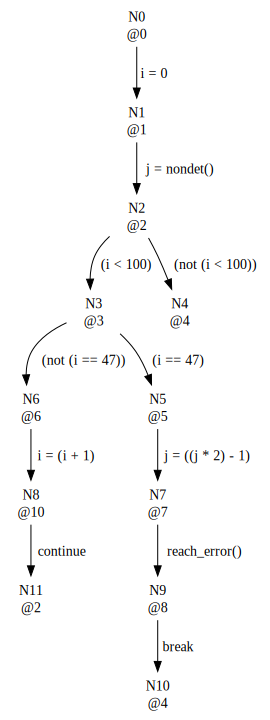

In [18]:
CFANode.index = 0  # reset the CFA node indices to produce identical output on re-execution
cfa_creator = CFACreator()
cfa_creator.visit(tree)
cfa_root = cfa_creator.root

cpa = ARGCPA(
        LocationCPA(cfa_root)
    )

waitlist = set()
reached = set()
init = cpa.get_initial_state()
waitlist.add(init)
reached.add(init)
algo = MCAlgorithm(cpa)
algo.run(reached, waitlist)
dot = graphable_to_dot(
        GraphableARGState(init),
        nodeattrs={"style": "filled", "shape": "box", "color": "white"},
    )
dot

### CompositeCPA: Achieving synergy with several CPAs

Several CPAs can be used in parallel to achieve synergy.
For this purpose, we need `CompositeCPA`, which is given in the next cell.
`CompositeCPA` delegates the merge and stop operations to the corresponding merge and stop operators of each component CPA.
The implementation is given, and you can proceed to the next task.

In [19]:
import itertools

class CompositeState(AbstractState):
    def __init__(self, wrapped_states):
        self.wrapped_states = wrapped_states

    def is_target(self):
        return any(
            [
                hasattr(state, "is_target") and state.is_target()
                for state in self.wrapped_states
            ]
        )

    def __eq__(self, other):
        if other is self:
            return True
        if len(self.wrapped_states) != len(other.wrapped_states):
            return False
        return all(a == b for (a, b) in zip(self.wrapped_states, other.wrapped_states))
            
    def __hash__(self):
        return tuple(
            wrapped_state.__hash__ for wrapped_state in self.wrapped_states
        ).__hash__()

    def __str__(self):
        return "|%s|" % "|\n|".join([str(state) for state in self.wrapped_states])


class CompositeStopOperator(AbstractState):
    def __init__(self, wrapped_stop_operators):
        self.wrapped_stop_operators = wrapped_stop_operators

    def stop(self, e, reached):
        return any( # Exists any reached state that covers e?
                   all(# All components of e are covered by the corresponding component of eprime?
                       stop_op.stop(e_inner, [eprime_inner])
                       for stop_op, e_inner, eprime_inner in zip(self.wrapped_stop_operators, e.wrapped_states, eprime.wrapped_states)
                   )
                   for eprime in reached
               )


class CompositeTransferRelation(TransferRelation):
    def __init__(self, wrapped_transfer_relations):
        self.wrapped_transfer_relations = wrapped_transfer_relations

    def get_abstract_successors(self, predecessor):
        location_states = [
            state
            for state in predecessor.wrapped_states
            if isinstance(state, LocationState)
        ]
        if len(location_states) == 0:
            return [
                CompositeState(product)
                for product in itertools.product(
                    *[
                        transfer.get_abstract_successors(state)
                        for (transfer, state) in zip(
                            self.wrapped_transfer_relations, predecessor.wrapped_states
                        )
                    ]
                )
            ]
        else:
            location_state = location_states[0]
            result = list()
            for edge in location_state.location.leaving_edges:
                result += self.get_abstract_successors_for_edge(predecessor, edge)
            return result

    def get_abstract_successors_for_edge(self, predecessor, edge):
        return [
            CompositeState(product)
            for product in itertools.product(
                *[
                    transfer.get_abstract_successors_for_edge(state, edge)
                    for (transfer, state) in zip(
                        self.wrapped_transfer_relations, predecessor.wrapped_states
                    )
                ]
            )
        ]


class CompositeMergeOperator(MergeOperator):
    """
    Merge-Agree: All wrapped states are merged pairwise.
    Example:
    
        merge((l, e), (l', e')) = (merge_L(l, l'), merge_E(e, e'))
        
    If any of the resulting merges does not cover both its input states
    (i.e., e \\leq merge_E(e, e') and e' \\leq merge_E(e, e'))
    then the second input (e.g., (l', e')) is returned.
    """
    
    def __init__(self, wrapped_merge_operators, wrapped_stop_operators):
        self.wrapped_merge_operators = wrapped_merge_operators
        self.wrapped_stop_operators = wrapped_stop_operators

    def merge(self, state1, state2):
        merge_results = list()
        wrapped_states1 = state1.wrapped_states
        wrapped_states2 = state2.wrapped_states
        for s1, s2, merge_operator, stop_operator in zip(
            wrapped_states1, wrapped_states2, self.wrapped_merge_operators, self.wrapped_stop_operators
        ):
            merge_result = merge_operator.merge(s1, s2)
            # Use the stop operator to check whether the merge result covers s1.
            # If it does not, we prevent merging for all wrapped states and return
            # state2.
            if not stop_operator.stop(s1, [merge_result]):
                return state2
            merge_results.append(merge_result)
        if all(sold == snew for sold, snew in zip(wrapped_states2, merge_results)):
            # If all merges were merge^sep, there's no need to create a new object
            # and we return state2.
            return state2
        return CompositeState(merge_results)


class CompositeCPA(CPA):
    def __init__(self, wrapped_cpas):
        self.wrapped_cpas = wrapped_cpas

    def get_initial_state(self):
        return CompositeState(
            [wrapped_cpa.get_initial_state() for wrapped_cpa in self.wrapped_cpas]
        )

    def get_stop_operator(self):
        return CompositeStopOperator(
            [wrapped_cpa.get_stop_operator() for wrapped_cpa in self.wrapped_cpas]
        )

    def get_merge_operator(self):
        return CompositeMergeOperator(
            [cpa.get_merge_operator() for cpa in self.wrapped_cpas],
            [cpa.get_stop_operator() for cpa in self.wrapped_cpas]
        )

    def get_transfer_relation(self):
        return CompositeTransferRelation(
            [wrapped_cpa.get_transfer_relation() for wrapped_cpa in self.wrapped_cpas]
        )

#### Task 7: Implementing the CPA algorithm (15 points)

To have a configurable way to explore the state space,
let's extend the model-checking algorithm to the CPA algorithm.

In [20]:
class CPAAlgorithm:
    def __init__(self, cpa):
        self.cpa = cpa

    # DONE Task 7 (cf. Algorithm 2 in Section 16.3.3 of the Handbook)
    def run(self, reached, waitlist):
        while len(waitlist) > 0:
            e = waitlist.pop()

            for e_prime in self.cpa.get_transfer_relation().get_abstract_successors(e):
                # store states that have to be added/removed from the sets here, to prevent modification during iteration
                to_add = set()
                to_remove = set()
                
                for e_reached in reached:
                    e_merged =  self.cpa.get_merge_operator().merge(e, e_reached)
                    if e_merged != e_reached:
                        to_add.add(e_merged)
                        to_remove.add(e_reached)
                        
                if not self.cpa.get_stop_operator().stop(e_prime, reached):
                    to_add.add(e_prime)
                
                reached -= to_remove
                reached |= to_add
                waitlist -= to_remove
                waitlist |= to_add
        
        return

### Value Analysis via ValueAnalysisCPA

To achieve a minimal value analysis,
we will design a CPA that realizes constant propagation and
a PropertyCPA that enables us to specify reachability by checking whether the function `reach_error` was called.

To test our implementation, we use the following two example programs:

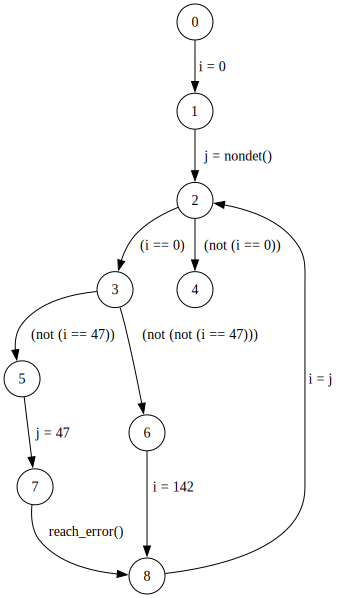

In [21]:
simple_program = \
"""
i = 0
j = nondet()
while i==0:
  if not i == 47:
    j = 47
    reach_error()
  else:
    i = 142
  i = j
"""
simple_program2 = \
"""
i=0
j=0
while i==0:
  j=1
"""
tree = ast.parse(simple_program)
tree2 = ast.parse(simple_program2)

CFANode.index = 0  # reset the CFA node indices to produce identical output on reexecution
cfa_creator = CFACreator()
cfa_creator.visit(tree)
graphable_to_dot(GraphableCFANode(cfa_creator.root))

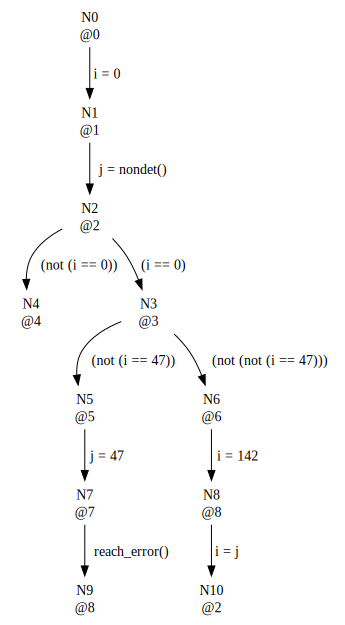

In [22]:
ARGState.index = 0
CFANode.index = 0  # reset the CFA node indices to produce identical output on reexecution
cfa_creator = CFACreator()
cfa_creator.visit(tree)
cfa_root = cfa_creator.root

cpa = ARGCPA(
        LocationCPA(cfa_root)
    )

waitlist = set()
reached = set()
init = cpa.get_initial_state()
waitlist.add(init)
reached.add(init)
algo = MCAlgorithm(cpa)
algo.run(reached, waitlist)
dot = graphable_to_dot(
        GraphableARGState(init),
        nodeattrs={"style": "filled", "shape": "box", "color": "white"},
    )
dot

#### Task 8: Supporting arithmetic operators in value analysis (10 points)

To support value analysis, the transfer relation of our CPA needs to understand the semantics of the arithmetic operators, such as `+,-,*,/,>,==`.
Below is a skeleton of how a CPA for value analysis can be constructed.
The implementation of arithmetic operators is left as TODOs.
We again use the visitor pattern for the implementation.

(5 points for the implementation in class `ValueExpressionVisitor`; 5 points for each test program. Note that we will have hidden programs that may require more support of the arithmetic operators.)

In [23]:
class ValueState:
    def __init__(self, other=None):
        if other:
            self.valuation = copy.copy(other.valuation)
        else:
            self.valuation = dict()

    def subsumes(self, other):
        return all(
            [
                not key in self.valuation or self.valuation[key] == value
                for (key, value) in other.valuation.items()
            ]
        )

    def __eq__(self, other):
        return self.valuation == other.valuation

    def __hash__(self):
        return tuple(
            (k, v)
            for (k, v) in sorted(self.valuation.items(), key=lambda item: item[0])
        ).__hash__()

    def __str__(self):
        return "{%s}" % ",".join(
            ["->".join((k, str(v))) for (k, v) in self.valuation.items()]
        )

In [24]:
class ValueExpressionVisitor(ast.NodeVisitor):
    def __init__(self, valuation):
        self.valuation = valuation
        self.lstack = list()
        self.rstack = list()

    def visit_Name(self, node):
        if isinstance(node.ctx, ast.Store):
            self.lstack.append(node.id)
        elif isinstance(node.ctx, ast.Load):
            var_name = node.id
            self.rstack.append(self.get_value_of(var_name))

    def visit_Num(self, node):
        self.rstack.append(Value(node.n))

    def visit_NameConstant(self, node):
        self.rstack.append(Value(node.value))
        
    def visit_UnaryOp(self, node):
        self.visit(node.operand)
        result = self.rstack.pop()
        if isinstance(node.op, ast.Not):
            self.rstack.append(result.__not__())
        elif isinstance(node.op, ast.USub):
            self.rstack.append(result.neg())
        elif isinstance(node.op, ast.UAdd):
            self.rstack.append(result) # unary add does not do anything for integers
        else:
            # TODO Task 8: implement other unary operators like unary negation
            raise NotImplementedError("Operator %s is not implemented!" % node.op)

    def visit_Compare(self, node):
        self.visit(node.left)
        left_result = self.rstack.pop()
        comp_results = list()
        for comparator in node.comparators:
            self.visit(comparator)
            comp_results.append(self.rstack.pop())
        # we only support simple compares like 1<2 for now, not something like 1<2<3:
        assert len(comp_results) == 1
        assert len(node.ops) == 1
        op = node.ops[0]
        if isinstance(op,ast.Eq):
            self.rstack.append(left_result.__equal__(comp_results[0]))
        elif isinstance(op,ast.Gt):
            self.rstack.append(left_result.gt(comp_results[0]))
        elif isinstance(op,ast.GtE):
            self.rstack.append(left_result.gte(comp_results[0]))
        elif isinstance(op,ast.Lt):
            self.rstack.append(left_result.lt(comp_results[0]))
        elif isinstance(op,ast.LtE):
            self.rstack.append(left_result.lte(comp_results[0]))
        elif isinstance(op,ast.NotEq):
            self.rstack.append(left_result.neq(comp_results[0]))
        elif isinstance(op,ast.Is):
            self.rstack.append(left_result.__is__(comp_results[0]))
        elif isinstance(op,ast.IsNot):
            self.rstack.append(left_result.__isnot__(comp_results[0]))
        elif isinstance(op,ast.In):
            self.rstack.append(left_result.__in__(comp_results[0]))
        elif isinstance(op,ast.NotIn):
            self.rstack.append(left_result.__notin__(comp_results[0]))
        else:
            # TODO Task 8: implement other comparison operators like >,<,>=,<=
            raise NotImplementedError("Operator %s is not implemented!" % op)

    # DONE Task 8: implement other operations like subtraction or multiplication for hidden programs
    def visit_Add(self, node):
        self.visit(node.left)
        left_result = self.rstack.pop()
        self.visit(node.right)
        right_result = self.rstack.pop()
        self.rstack.append(left_result.__add__(right_result))

    def visit_Sub(self, node):
        self.visit(node.left)
        left_result = self.rstack.pop()
        self.visit(node.right)
        right_result = self.rstack.pop()
        self.rstack.append(left_result.__sub__(right_result))

    def visit_Mul(self, node):
        self.visit(node.left)
        left_result = self.rstack.pop()
        self.visit(node.right)
        right_result = self.rstack.pop()
        self.rstack.append(left_result.__mul__(right_result))

    def visit_Div(self, node):
        self.visit(node.left)
        left_result = self.rstack.pop()
        self.visit(node.right)
        right_result = self.rstack.pop()
        self.rstack.append(left_result.__div__(right_result))

    def visit_Mod(self, node):
        self.visit(node.left)
        left_result = self.rstack.pop()
        self.visit(node.right)
        right_result = self.rstack.pop()
        self.rstack.append(left_result.__mod__(right_result))

    
    def get_value_of(self, varname):
        return (
            Value(self.valuation[varname])
            if varname in self.valuation
            else Value.get_top()
        )

    def update(self, other_valuation):
        for lhs, rhs in zip(self.lstack, self.rstack):
            if rhs == Value.get_top():
                other_valuation.pop(lhs, None)
            else:
                other_valuation[lhs] = rhs.actual

class Value:
    __top = None

    @staticmethod
    def get_top():
        """ Static access method. """
        if Value.__top is None:
            Value.__top = Value(top=True)
        return Value.__top

    def __init__(self, actual=None, top=False):
        assert not isinstance(actual, Value)
        if top == True and Value.__top != None:
            """ Virtually private constructor for Top."""
            raise Exception("There may only be one top state!")
        else:
            self.actual = actual
        
    def __equal__(self, other):
        if self is Value.get_top():
            return self
        if other is Value.get_top():
            return other
        else:
            return Value(self.actual == other.actual)

    def neq(self, other):
        if self is Value.get_top():
            return self
        if other is Value.get_top():
            return other
        else:
            return Value(self.actual != other.actual)
    
    # We need this for negation of Top, since both are True!
    def __not__(self):  
        if self == Value.get_top():
            return self
        else:
            return Value(not self.actual.__bool__())

    # DONE Task 8: greater than
    def gt(self,other):
        if self == Value.get_top() or other == Value.get_top():
            return Value.get_top()
        else:
            return Value(self.actual > other.actual)
    def lt(self,other):
        if self == Value.get_top() or other == Value.get_top():
            return Value.get_top()
        else:
            return Value(self.actual < other.actual)

    def gte(self,other):
        if self == Value.get_top() or other == Value.get_top():
            return Value.get_top()
        else:
            return Value(self.actual >= other.actual)
    def lte(self,other):
        if self == Value.get_top() or other == Value.get_top():
            return Value.get_top()
        else:
            return Value(self.actual <= other.actual)

    def __is__(self,other):
        if self == Value.get_top() or other == Value.get_top():
            return Value.get_top()
        else:
            return Value(self.actual is other.actual)
    def __isnot__(self,other):
        if self == Value.get_top() or other == Value.get_top():
            return Value.get_top()
        else:
            return Value(not self.actual is other.actual)

    def __in__(self,other):
        if self == Value.get_top() or other == Value.get_top():
            return Value.get_top()
        else:
            return Value(self.actual in other.actual)
    def __notin__(self,other):
        if self == Value.get_top() or other == Value.get_top():
            return Value.get_top()
        else:
            return Value(not self.actual in other.actual)


    # DONE Task 8: negation
    def neg(self):
        if self == Value.get_top():
            return self
        else:
            return Value(-self.actual)
    
    # DONE Task 8: return a Value that wraps the result of the addition.
    # remember to consider the case where at least one of the operands is top!
    def __add__(self, other):
        if self == Value.get_top() or other == Value.get_top():
            return Value.get_top()
        else:
            return Value(self.actual + other.actual)
    
    # DONE Task 8: implement other operations like subtraction or multiplication for hidden programs
    def __sub__(self, other):
        if self == Value.get_top() or other == Value.get_top():
            return Value.get_top()
        else:
            return Value(self.actual - other.actual)
    
    def __mul__(self, other):
        # multiplication with zero is special case:
        if self.actual == 0 or other.actual == 0:
            return Value(0)
        elif self == Value.get_top() or other == Value.get_top():
            return Value.get_top()
        else:
            return Value(self.actual * other.actual)

    def __div__(self, other):
        if self == Value.get_top() or other == Value.get_top():
            return Value.get_top()
        else:
            return Value(self.actual / other.actual)
    
    def __mod__(self, other):
        if self == Value.get_top() or other == Value.get_top():
            return Value.get_top()
        else:
            return Value(self.actual % other.actual)

In [25]:
class ValueTransferRelation(TransferRelation):
    def get_abstract_successors(self, predecessor):
        raise NotImplementedError(
            "successors without edge not possible for Value Analysis!"
        )

    def get_abstract_successors_for_edge(self, predecessor, edge):
        v = ValueExpressionVisitor(predecessor.valuation)
        kind = edge.instruction.kind
        if kind == InstructionType.STATEMENT:
            v.visit(edge.instruction.expression)
            successor = ValueState(predecessor)
            v.update(successor.valuation)
            return [successor]
        elif kind == InstructionType.ASSUMPTION:
            v.visit(edge.instruction.expression)
            # lstack should be empty because there is no lhs in an assumption:
            assert len(v.lstack) == 0
            # there should be one value on rstack, namely what the assumption evaluated to:
            assert len(v.rstack) == 1
            result = v.rstack.pop()
            if result == Value.get_top():
                return [predecessor]
            passed = True if result.actual else False
            return [predecessor] if passed else []
        else:
            raise ValueError("invalid value")

class ValueStopOperator:
    def stop(self, e, reached): # stop-sep
        return len([eprime for eprime in reached if e.subsumes(eprime)]) > 0


class ValueAnalysisCPA(CPA):
    def get_initial_state(self):
        return ValueState()

    def get_stop_operator(self):
        return ValueStopOperator()

    def get_merge_operator(self):
        return MergeSepOperator()

    def get_transfer_relation(self):
        return ValueTransferRelation()

Let's try to verify `simple_program` using the model-checking algorithm.
Note that, you do not need to implement every arithmetic operator to handle this task.
Can your value analysis find a bug in `simple_program`?

/tmp/ipykernel_447500/17333401.py:15: DeprecationWarning: Attribute n is deprecated and will be removed in Python 3.14; use value instead
  self.rstack.append(Value(node.n))


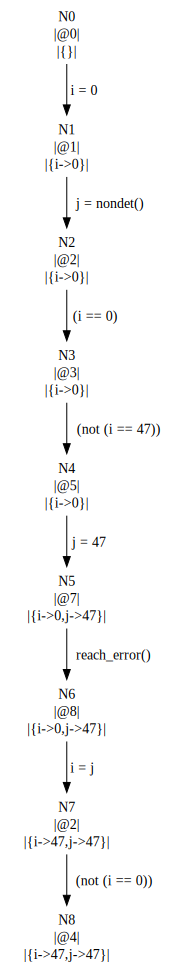

In [26]:
ARGState.index = 0
CFANode.index = 0  # reset the CFA node indices to produce identical output on re-execution
cfa_creator = CFACreator()
cfa_creator.visit(tree)
cfa_root = cfa_creator.root

cpa = ARGCPA(CompositeCPA([LocationCPA(cfa_root), ValueAnalysisCPA()]))

waitlist = set()
reached = set()
init = cpa.get_initial_state()
waitlist.add(init)
reached.add(init)
algo = MCAlgorithm(cpa)
algo.run(reached, waitlist)
dot = graphable_to_dot(
        GraphableARGState(init),
        nodeattrs={"style": "filled", "shape": "box", "color": "white"},
    )
dot

Next, let's try to verify `simple_program2`, which contains a while-loop.
Can your value analysis terminate on this program?

/tmp/ipykernel_447500/17333401.py:15: DeprecationWarning: Attribute n is deprecated and will be removed in Python 3.14; use value instead
  self.rstack.append(Value(node.n))


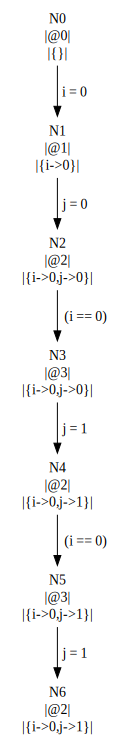

In [27]:
ARGState.index = 0
CFANode.index = 0  # reset the CFA node indices to produce identical output on re-execution
cfa_creator = CFACreator()
cfa_creator.visit(tree2)
cfa_root = cfa_creator.root

cpa = ARGCPA(CompositeCPA([LocationCPA(cfa_root), ValueAnalysisCPA()]))

waitlist = set()
reached = set()
init = cpa.get_initial_state()
waitlist.add(init)
reached.add(init)
algo = MCAlgorithm(cpa)
algo.run(reached, waitlist)
dot = graphable_to_dot(
        GraphableARGState(init),
        nodeattrs={"style": "filled", "shape": "box", "color": "white"},
    )
dot

### PropertyCPA

In this part, we will write a CPA that checks for whether the function `reach_error` has been invoked on the explored path.
The `__str__` method of the states of that CPA should mark each state as either `unsafe` or `safe`
depending on whether this call has been reached or not.
(You are on your own here, we will not give you any code to start with.
You might want to create a visitor that checks for call nodes in the instructions and use that one in your transfer relation.)

#### Task 9: Implementing PropertyCPA (10 points)

In [28]:
#DONE Task 9: write the PropertyCPA
class PropertyState(AbstractState):
    def __init__(self, is_safe):
        self.safe = is_safe

    def subsumes(self, other):
        return other.safe == None or self.safe == other.safe

    def __eq__(self, other):
        return self.safe == other.safe

    def __hash__(self):
        return self.safe.__hash__()

    def __str__(self):
        if self.safe:
            return 'safe'
        else:
            return 'unsafe'



class FunctionCallVisitor(ast.NodeVisitor):
    def __init__(self, previous_state):
        self.state = previous_state

    def visit_Call(self, node):
        # if reach_error is called, update the state to unsafe
        if node.func.id == 'reach_error':
            self.state = PropertyState(False)

        return self.generic_visit(node)

class PropertyTransferRelation(TransferRelation):
    def get_abstract_successors(self, predecessor):
        raise NotImplementedError(
            "successors without edge not possible for Property Analysis!"
        )

    def get_abstract_successors_for_edge(self, predecessor, edge):
        v = FunctionCallVisitor(predecessor)
        kind = edge.instruction.kind
        if kind == InstructionType.STATEMENT:
            v.visit(edge.instruction.expression)
            return [v.state]
        elif kind == InstructionType.ASSUMPTION:
            v.visit(edge.instruction.expression)
            return [v.state]
        else:
            raise ValueError("invalid value")

class PropertyStopOperator:
    def stop(self, e, reached):
        return [eprime for eprime in reached if eprime.subsumes(e)]

class PropertyCPA(CPA):
    def get_initial_state(self):
        return PropertyState(True)

    def get_stop_operator(self):
        return PropertyStopOperator()

    def get_merge_operator(self):
        # simply use merge sep
        return MergeSepOperator()

    def get_transfer_relation(self):
        return PropertyTransferRelation()

You can test your implementation by composing your PropertyCPA $\mathbb{O}$ with LocationCPA $\mathbb{L}$ and ValueAnalysisCPA $\mathbb{V}$:

/tmp/ipykernel_447500/17333401.py:15: DeprecationWarning: Attribute n is deprecated and will be removed in Python 3.14; use value instead
  self.rstack.append(Value(node.n))


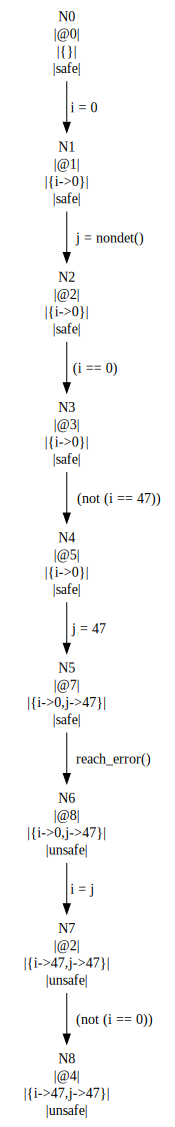

In [29]:
ARGState.index = 0
CFANode.index = 0  # reset the CFA node indices to produce identical output on reexecution
cfa_creator = CFACreator()
cfa_creator.visit(tree)
cfa_root = cfa_creator.root

cpa = ARGCPA(CompositeCPA([LocationCPA(cfa_root), ValueAnalysisCPA(), PropertyCPA()]))

waitlist = set()
reached = set()
init = cpa.get_initial_state()
waitlist.add(init)
reached.add(init)
algo = MCAlgorithm(cpa)
algo.run(reached, waitlist)
dot = graphable_to_dot(
        GraphableARGState(init),
        nodeattrs={"style": "filled", "shape": "box", "color": "white"},
    )
dot

### Model Checking vs. Data-Flow Analysis

Now, it is time to revisit the exercise sheet from Week 3.
There we had given the following program:

```c
int x;
int y; // defined, but unknown

if (y > 0) {
  x = 0;
} else {
  x = -1;
}

if (x > 0) {
ERR:;
}

```

We convert the program above into a semantically equivalent Python program and mark the error location using `reach_error()`.

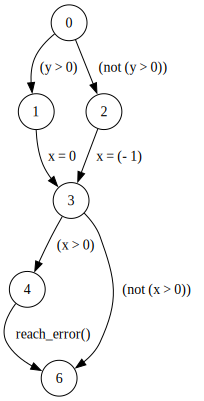

In [30]:
program1_source = \
"""
if y>0:
  x = 0
else:
  x = -1
if x>0:
  reach_error()
"""
program1 = ast.parse(program1_source)
CFANode.index = 0  # reset the CFA node indices to produce identical output on re-execution
cfa_creator = CFACreator()
cfa_creator.visit(program1)
cfa_root = cfa_creator.root
graphable_to_dot(GraphableCFANode(cfa_root))

#### Extend your implementation of the value analysis

Determine which features still need to be implemented in the Value Analysis code above such that
the following analysis succeeds in producing the solutions to the exercise sheet:

/tmp/ipykernel_447500/17333401.py:15: DeprecationWarning: Attribute n is deprecated and will be removed in Python 3.14; use value instead
  self.rstack.append(Value(node.n))


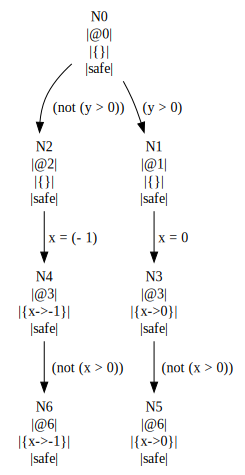

In [31]:
# Run the MCAlgorithm on program1:

ARGState.index = 0
cpa = ARGCPA(CompositeCPA([LocationCPA(cfa_root), ValueAnalysisCPA(), PropertyCPA()]))

waitlist = set()
reached = set()
init = cpa.get_initial_state()
waitlist.add(init)
reached.add(init)
algo = MCAlgorithm(cpa)
algo.run(reached, waitlist)
dot = graphable_to_dot(
        GraphableARGState(init),
        nodeattrs={"style": "filled", "shape": "box", "color": "white"},
    )
dot

#### Task 10: Implementing the merge-join operators (3 points)

Please implement a different merge operator that joins the `ValueState`s instead of the currently used `MergeSepOperator`.

In [32]:
class ValueMergeOperator:
    def merge(self, state1, state2):
        assert(isinstance(state1, ValueState))
        assert(isinstance(state2, ValueState))
        #DONE Task 10: implement merge operator that always joins
        if state1 is state2 and state1.valuation == state2.valuation:
            return state2
        else:
            result = ValueState()
            for (key, val) in state2.valuation.items():
                if key in state1.valuation and state1.valuation[key] == val:
                    result.valuation[key] = val
            return result

# This will update the ValueAnalysisCPA to use the new merge operator.
# This way we will not have to jump all the way up in this notebook to implement the changes.
ValueAnalysisCPA.get_merge_operator = lambda x : ValueMergeOperator()

Let's execute the CPA algorithm again with the merge-join operator for `ValueAnalysisCPA`.

/tmp/ipykernel_447500/17333401.py:15: DeprecationWarning: Attribute n is deprecated and will be removed in Python 3.14; use value instead
  self.rstack.append(Value(node.n))


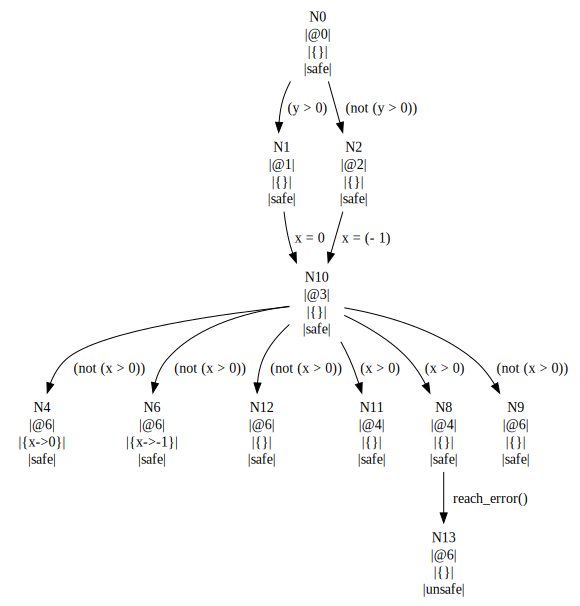

In [33]:
# Execute the CPAAlgorithm with the ValueAnalysisCPA as Data-Flow Analysis:
CFANode.index = 0  # reset the CFA node indices to produce identical output on re-execution
ARGState.index = 0 # reset the ARG node indices to produce identical output on re-execution
cfa_creator = CFACreator()
cfa_creator.visit(program1)
cfa_root = cfa_creator.root

cpa = ARGCPA(CompositeCPA([LocationCPA(cfa_root), ValueAnalysisCPA(), PropertyCPA()]))

waitlist = set()
reached = set()
init = cpa.get_initial_state()
waitlist.add(init)
reached.add(init)
algo = CPAAlgorithm(cpa)
algo.run(reached, waitlist)
dot = graphable_to_dot(
        GraphableARGState(init),
        nodeattrs={"style": "filled", "shape": "box", "color": "white"},
    )
dot